In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
import keras.backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import os
import warnings

warnings.filterwarnings("ignore")

## matplotlib stylings
plt.rcParams['figure.figsize'] = 15,9

In [51]:
filter_not_selective_data = pd.read_csv('dataset/filtered_data.csv')

print(filter_not_selective_data.shape)

(44400, 785)


In [52]:
# Extract images and labels
filtered_not_selective_images = filter_not_selective_data.iloc[:, 1:].values.astype('float32')
filtered_not_selective_labels = filter_not_selective_data.iloc[:, 0].values

print(filtered_not_selective_images.shape)
print(filtered_not_selective_labels.shape)

(44400, 784)
(44400,)


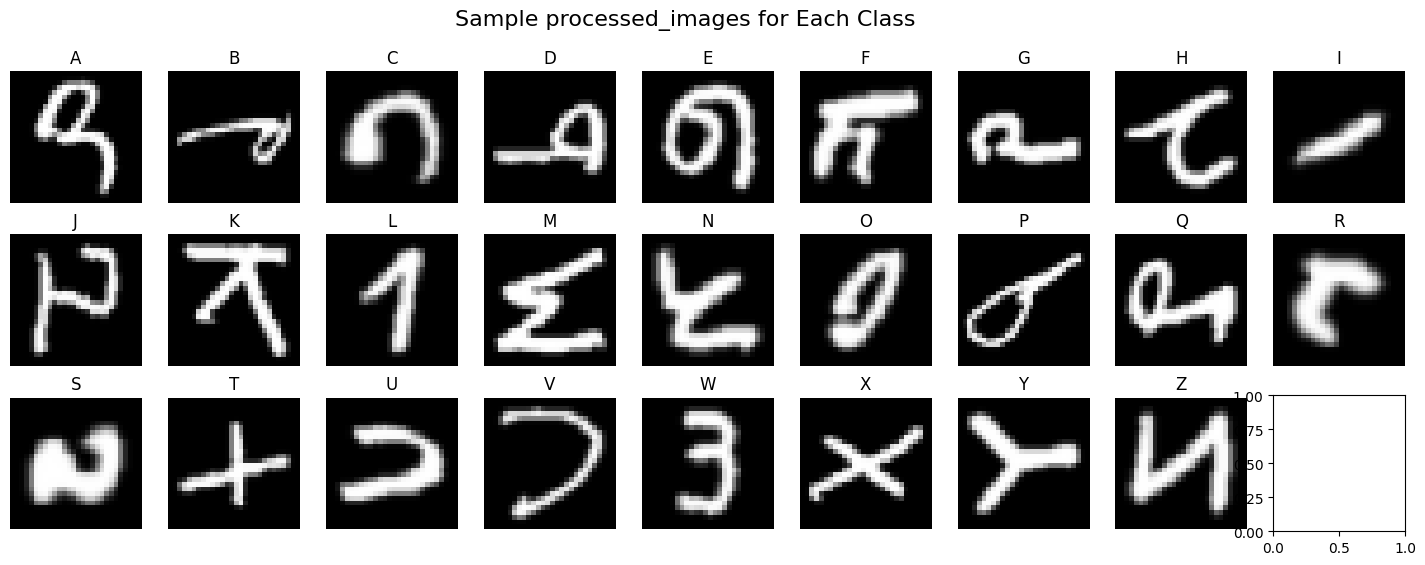

In [18]:
label_to_char = {i: chr(64 + i) for i in range(1, 27)}

# Display sample filtered_not_selective_images for each class
unique_labels = np.unique(filtered_not_selective_labels)
fig, axs = plt.subplots(3, 9, figsize=(18, 6))
fig.suptitle('Sample processed_images for Each Class', fontsize=16)
for i, label in enumerate(unique_labels):
    class_processed_images = filtered_not_selective_images[filtered_not_selective_labels == label]
    ax = axs[i // 9, i % 9]
    ax.imshow(class_processed_images[0].reshape(28, 28), cmap='gray')
    # ax.set_title(f'{label}')    
    ax.set_title(f'{label_to_char[label]}') #can put like this to change to English Letters
    ax.axis('off')
plt.show()

In [53]:
filtered_not_selective_images = filtered_not_selective_images.reshape(-1,28,28,1)
filtered_not_selective_images = (filtered_not_selective_images - 127.5) / 127.5  # Normalize the image to [-1, 1]

encoder = LabelEncoder()
filtered_encoded_labels = encoder.fit_transform(filtered_not_selective_labels)

# Convert to one-hot encoding
filtered_one_hot_labels = tf.keras.utils.to_categorical(filtered_encoded_labels, num_classes=26)

In [54]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    filtered_not_selective_images, filtered_one_hot_labels, test_size=0.2, random_state=42
)

# Check the shapes of the resulting datasets
print('Training set shape:', X_train_val.shape)
print('Validation set shape:', X_test.shape)

print('Training label:', y_train_val.shape)
print('Validation label:', y_test.shape)

Training set shape: (35520, 28, 28, 1)
Validation set shape: (8880, 28, 28, 1)
Training label: (35520, 26)
Validation label: (8880, 26)


In [55]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

# Check the shapes of the resulting datasets
print('Training set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)

print('Training label:', y_train.shape)
print('Validation label:', y_train.shape)

Training set shape: (28416, 28, 28, 1)
Validation set shape: (7104, 28, 28, 1)
Training label: (28416, 26)
Validation label: (28416, 26)


In [64]:
def c_report(model, X_test, y_test):
    # Predict the classes for the test set
    predictions = model.predict(X_test)

    # Get the most likely class
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Generate class labels from y_test
    unique_classes = np.unique(true_classes)
    class_labels = [f'class_{i}' for i in unique_classes]

    # Generate classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

def plot_confusion_matrix(model, X_test, y_test):
    # Predict the classes for the test set
    predictions = model.predict(X_test)

    # Get the most likely class
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix with adjusted color palette
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [32]:
def mb_conv_block(inputs, filter_num, expansion_factor, kernel_size, stride):
    # Expansion phase (Inverted Residual)
    x = Conv2D(filters=int(inputs.shape[-1] * expansion_factor), kernel_size=(1, 1), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    # Depthwise convolution phase
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    # Squeeze and Excitation phase
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, int(inputs.shape[-1] * expansion_factor)))(se)
    se = Dense(int(inputs.shape[-1] * expansion_factor // 4), activation='swish')(se)
    se = Dense(int(inputs.shape[-1] * expansion_factor), activation='sigmoid')(se)
    x = Multiply()([x, se])

    # Output phase (Linear)
    x = Conv2D(filters=filter_num, kernel_size=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Add identity shortcut if dimensions match
    if inputs.shape[-1] == filter_num and stride == 1:
        x = Add()([x, inputs])

    return x

In [33]:
def make_efficientnet_simplified(input_shape=(28, 28, 1), num_classes=26):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    # Block 1: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)

    # Block 2: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)

    # Block 3: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)

    # Block 4: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)

    # Block 5: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)

    # Block 6: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)

    # Block 7: MBConv Block
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(3, 3), stride=1)
    x = mb_conv_block(x, filter_num=16, expansion_factor=1, kernel_size=(5, 5), stride=1)

    # Global Average Pooling to reduce to a single vector per image
    x = GlobalAveragePooling2D()(x)

    # Fully connected layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [34]:
tf.keras.backend.clear_session()
eff_model = make_efficientnet_simplified(input_shape=(28, 28, 1), num_classes=26)
eff_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   288         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 32)   0           ['batch_normalization[0][0]']

In [35]:
eff_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)

In [36]:
# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

In [37]:
# Define learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.03
    if epoch < 3:
        return initial_lr
    elif epoch < 15:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.1

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [38]:
tf.keras.backend.clear_session()

epochs = 50

history = eff_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
888/888 [==============================] - 39s 28ms/step - loss: 0.8687 - acc: 0.7250 - val_loss: 1.2329 - val_acc: 0.7062 - lr: 0.0300
Epoch 2/50
888/888 [==============================] - 22s 25ms/step - loss: 0.4919 - acc: 0.8420 - val_loss: 1.4580 - val_acc: 0.6534 - lr: 0.0300
Epoch 3/50
888/888 [==============================] - 21s 24ms/step - loss: 0.4545 - acc: 0.8557 - val_loss: 1.4186 - val_acc: 0.6546 - lr: 0.0300
Epoch 4/50
888/888 [==============================] - 22s 24ms/step - loss: 0.2353 - acc: 0.9204 - val_loss: 0.2053 - val_acc: 0.9360 - lr: 0.0030
Epoch 5/50
888/888 [==============================] - 23s 25ms/step - loss: 0.1981 - acc: 0.9323 - val_loss: 0.1978 - val_acc: 0.9381 - lr: 0.0030
Epoch 6/50
888/888 [==============================] - 25s 28ms/step - loss: 0.1916 - acc: 0.9344 - val_loss: 0.1916 - val_acc: 0.9374 - lr: 0.0030
Epoch 7/50
888/888 [==============================] - 25s 28ms/step - loss: 0.1850 - acc: 0.9356 - val_loss: 0.1901 - 

In [39]:
#Plot Error and Accuracy
def plot_error_and_accuracy(hist, title):
  h = hist.history
  plt.style.use('ggplot')
  plt.figure(figsize=(15, 9))
  plt.plot(h['loss'], c='red', label='Training Loss')
  plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
  plt.plot(h['acc'], c='blue', label='Training Accuracy')
  plt.plot(h['val_acc'], c='blue', linestyle='--', label='Validation Accuracy')
  plt.xlabel("Number of Epochs")
  plt.legend(loc='best')
  plt.title(title)
  plt.xticks(range(0, len(h['loss'])+1, 2))
  plt.show()

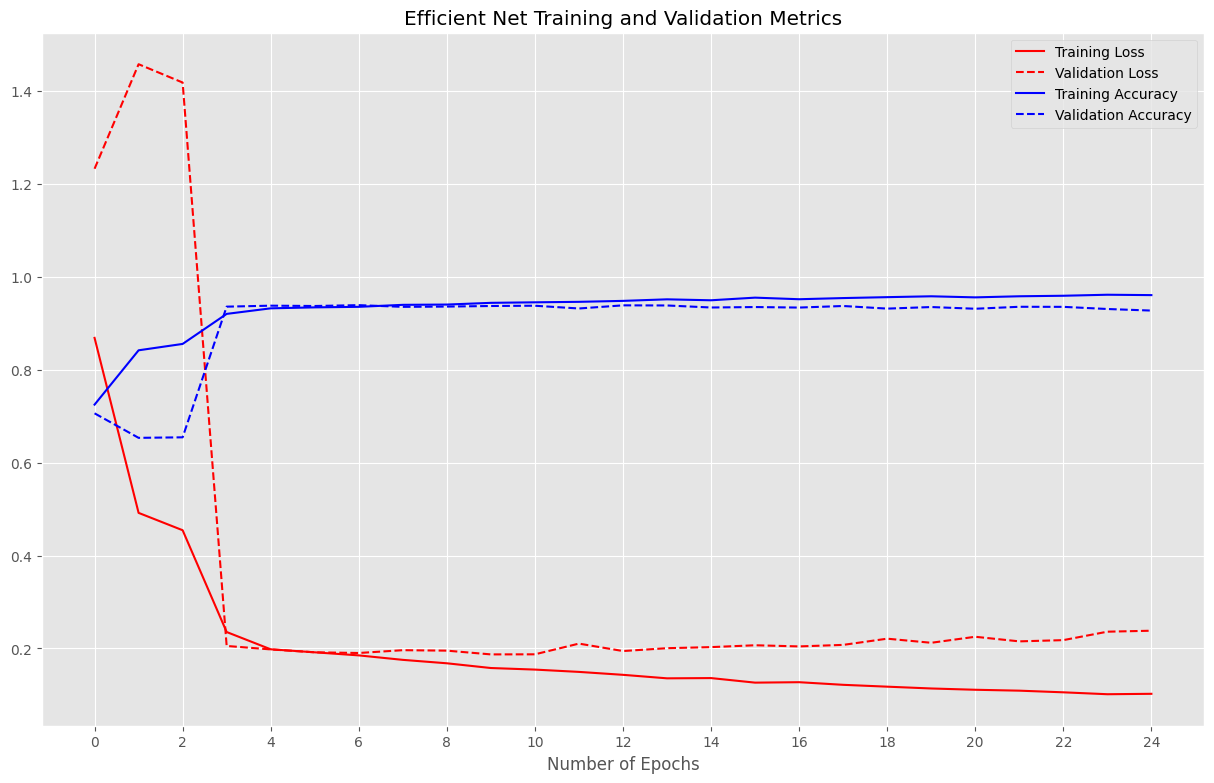

In [40]:
plot_error_and_accuracy(history, "Efficient Net Training and Validation Metrics")

In [57]:
# Predict the accuracy and loss for the test set
filtered_test_loss_accuracy = eff_model.evaluate(X_test,y_test, verbose=1)

# Access the accuracy and loss
filtered_eff_model_accuracy = filtered_test_loss_accuracy[1]
filtered_eff_model_loss = filtered_test_loss_accuracy[0]

# Print the accuracy and loss
print(f"Test Accuracy: {filtered_eff_model_accuracy:.4f}")
print(f"Test Loss: {filtered_eff_model_loss:.4f}")

278/278 [==============================] - 7s 24ms/step - loss: 0.1944 - acc: 0.9345
Test Accuracy: 0.9345
Test Loss: 0.1944


In [62]:
c_report(eff_model, X_test, y_test)

278/278 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

     class_0       0.93      0.94      0.93       341
     class_1       0.96      0.98      0.97       347
     class_2       0.98      0.97      0.98       331
     class_3       0.92      0.98      0.95       365
     class_4       0.94      0.98      0.96       330
     class_5       0.98      0.94      0.96       354
     class_6       0.83      0.84      0.84       353
     class_7       0.97      0.95      0.96       359
     class_8       0.68      0.85      0.76       350
     class_9       0.92      0.95      0.93       300
    class_10       0.99      0.97      0.98       341
    class_11       0.79      0.61      0.69       342
    class_12       0.99      0.99      0.99       316
    class_13       0.95      0.95      0.95       332
    class_14       0.99      0.94      0.96       348
    class_15       0.97      0.98      0.97       345
    class_16       0.90  

278/278 [==============================] - 6s 21ms/step


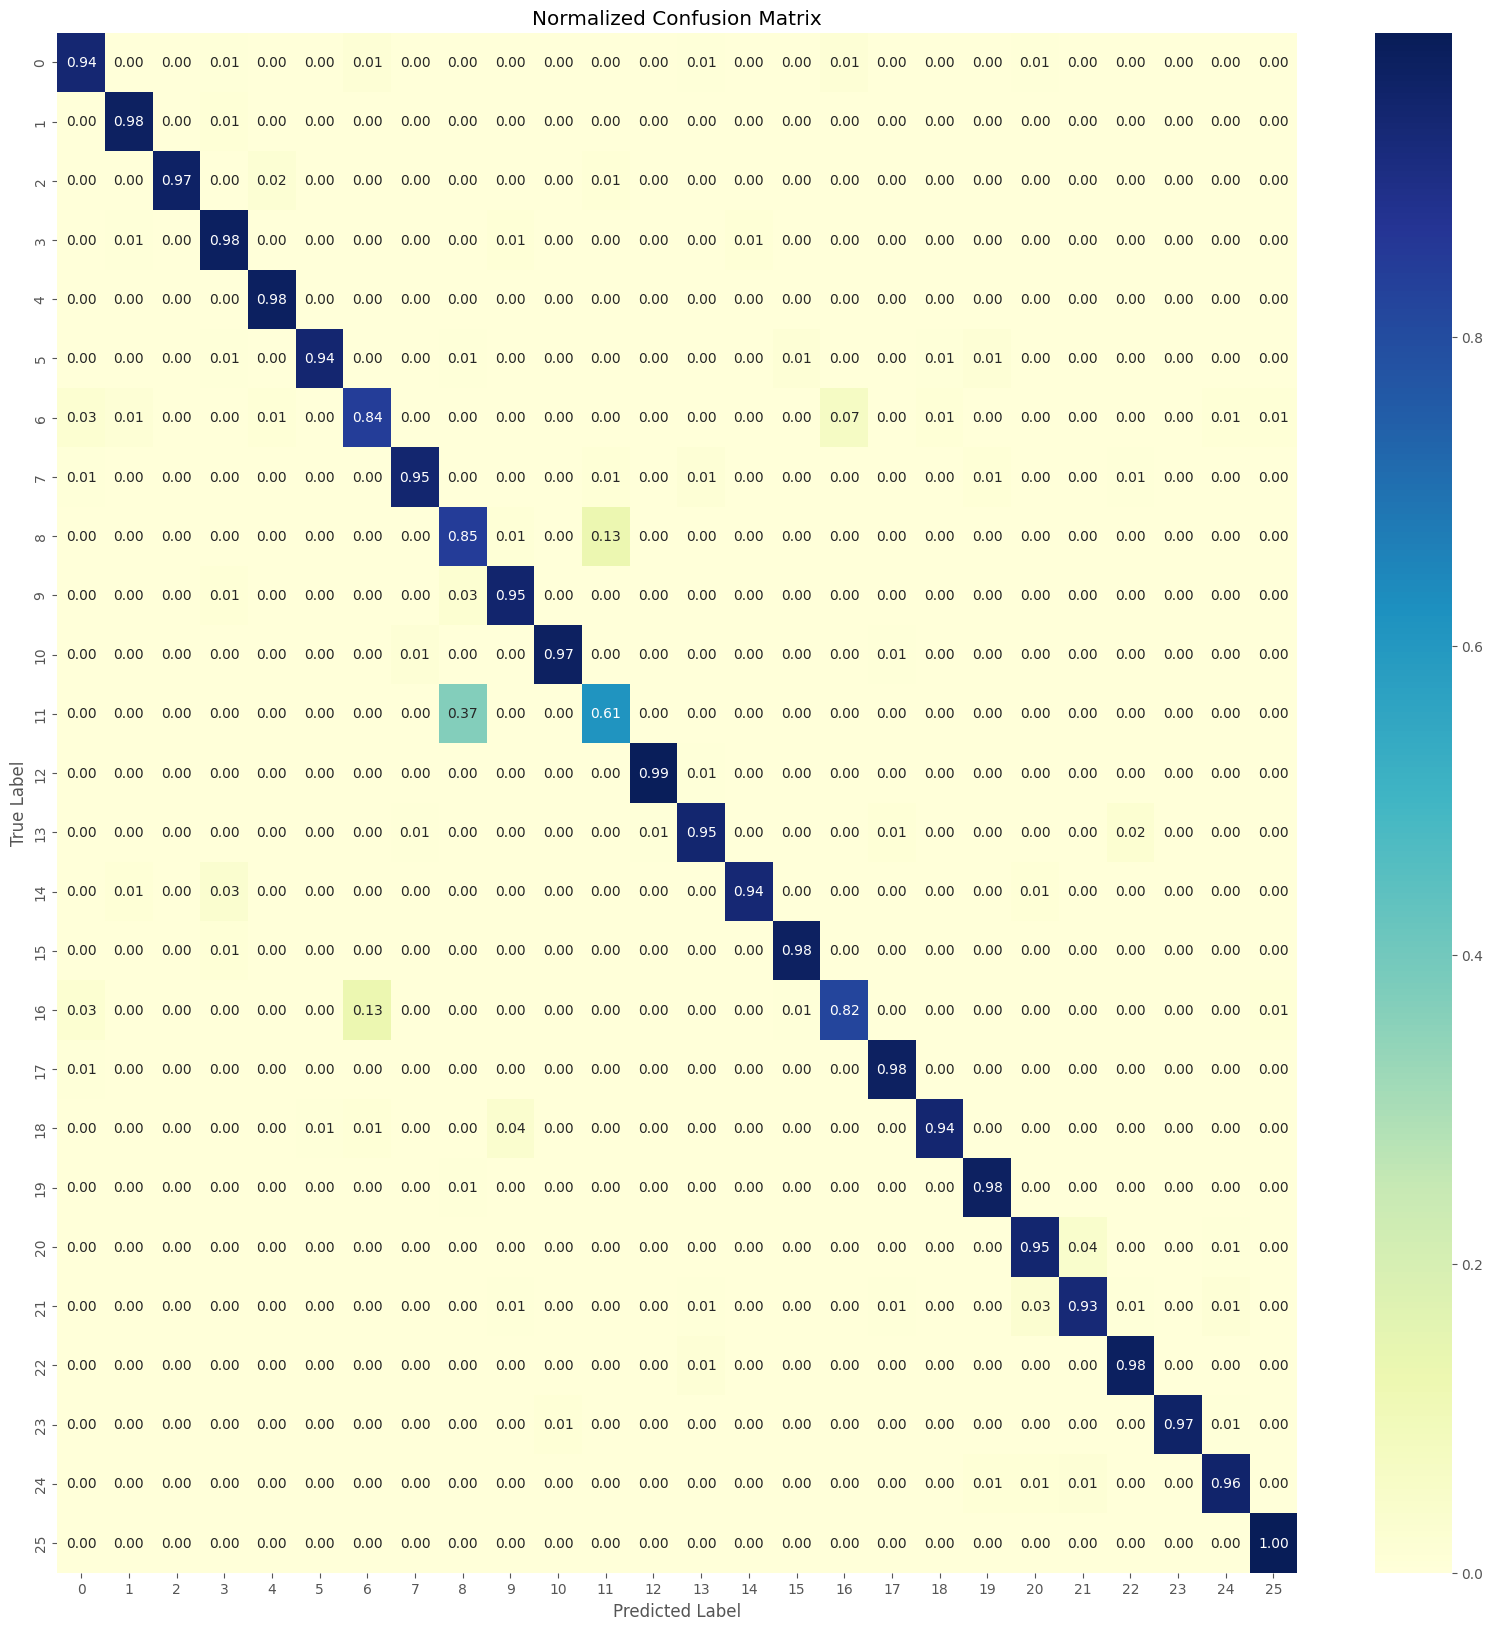

In [63]:
plot_confusion_matrix(eff_model, X_test, y_test)

----

In [77]:
save_dir = 'save_models'
model_filename = "specific_emnist_eff_net.h5"
model_path = os.path.join(save_dir, model_filename)

if os.path.exists(model_path):
    print(f"[INFO] Model {model_filename} already exists at {model_path}. Not saving.")
else:
    eff_model.save(model_path)
    print(f"[INFO] Model saved to: {model_path}")

[INFO] Model saved to: save_models\specific_emnist_eff_net.h5
